# Aula 3 - Tratamento de Dados Categóricos

Na aula de hoje, vamos conversar um pouco sobre:

- 1. Codificação de variáveis categóricas
- 2. Label Encoding
- 3. OneHot Encoding
- 4. ColumnTransformer e FunctionTransformer
- 5. Target Encoder

## 1. Codificação de Variáveis Categóricas

A grande maioria dos modelos Machine Learning são implementações de equações matemáticas, teoremas e relações de álgebra linear (lembrem-se do SVM!). Sendo assim, as implementações não estão preparadas para lidar com dados que são representados na forma de texto, como por exemplo, variáveis categóricas, sejam elas ordinais (quando existe uma **naturalmente** hierarquia do que é melhor e do que é pior) ou sejam elas nominais (não se sabe *a priori* se uma categoria é melhor ou pior que outras, pois essa inferência só pode ser feita dos dados amostrados.). Já vimos que existem muitas fontes de dados, e diferentes tipos de variáveis que podem ser extraídas dessas fontes, de forma que nós devemos ter adaptações para lidar com esses obstáculos.

<img src="https://1.bp.blogspot.com/-5Q-8Bp0BEdY/XhaKPxDvvFI/AAAAAAAAAmE/ZtURz0WKVCsBZsLhXT_TlEFar6g1CnDHgCLcBGAsYHQ/s1600/1.JPG">



Assim sendo, a técnica mais simples de transformação dos dados textuais em dados é conhecida como *Categorical Encoding*. Existem muitas outras técnicas de transformação de dados textuais, bem mais avançadas e que inclusive podem levar em consideração o sentido semântico da palavra, mas nessa aula vamos nos ater às técnicas mais simples. Em **Dados Não Estruturados**, vocês verão que existe um campo inteiramente dedicado a esse estudo, conhecido como *Natural Language Processing*.
Também é importante mencionar que nem todos os algoritmos demandam necessariamente a aplicação de codificação. Árvores de decisão e modelos em árvore, em geral, conseguem trabalhar com atributos codificados em textos.

<img src="https://mlfromscratch.com/content/images/2020/09/exercise_3-1.png" width=900px>

## 2. Label Encoding

O *Label Encoding* é a técnica mais simples de se realizar codificação de variáveis categóricas. Essencialmente funciona atribuindo simplesmente os valores numéricos para cada valor único da categoria encontrada

<img src="https://miro.medium.com/max/772/1*QQe-4476Oy3_dI1vhb3dDg.png">

No Python, implementamos o *label enconding* utilizando a classe `LabelEncoder` da biblioteca `scikit-learn`, cuja documentação pode ser encontrada [nesse link](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html). O `LabelEncoder` faz a identificação das categorias únicas num vetor de dados, ordena-as em ordem crescente e depois atribui os números na ordem que elas aparecem no vetor ordenado.

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, KFold
from sklearn.metrics import classification_report, r2_score, mean_absolute_error
from category_encoders.target_encoder import TargetEncoder


# ignorar warnings
warnings.filterwarnings('ignore')

In [2]:
# criando um vetor base
base = ['Miami', 'SaoPaulo', 'Barcelona', 'Paris']

# criando um dataframe de múltiplas amostras
categories = pd.DataFrame(np.random.choice(base, 50), columns=['city'])

# checando distribuições iniciais
categories.value_counts()

city     
Barcelona    18
SaoPaulo     12
Miami        10
Paris        10
dtype: int64

In [3]:
# aplicando o Label Encoder
le = LabelEncoder()
le.fit(categories.city)

# visualizando as classes identificadas
print('Classes Identificadas: ', le.classes_)

Classes Identificadas:  ['Barcelona' 'Miami' 'Paris' 'SaoPaulo']


In [4]:
# realizando a transformação de colunas
categories['city_le'] = le.transform(categories.city)

# checando a distribuição das classes codificadas
categories.city_le.value_counts()

0    18
3    12
1    10
2    10
Name: city_le, dtype: int64

In [5]:
# podemos querer recuperar as informações das categorias (para outros dados de teste)
city_test = pd.DataFrame(np.random.choice(list(range(4)), 20), columns=['city_cod'])

# aplicando a transformada inversa
city_test['city'] = le.inverse_transform(city_test.city_cod)

city_test.head()

,city_cod,city
0,2,Paris
1,2,Paris
2,1,Miami
3,1,Miami
4,1,Miami


<font color="red">No entanto, o uso do `LabelEncoder` deve ser feito com muito cuidado !!!</font>. Pensemos por um momento da implicação de simplesmente atribuir números às categorias. Fazendo dessa forma, o modelo pode receber a informação de que uma categoria é melhor que outra, simplesmente pelo fato da primeira ter recebido um valor maior que a segunda no Label Encoding. Isso é conhecido como *inferência a priori*, que significa quando o modelador inclui um conhecimento ou um viés previamente à modelagem e, portanto, o modelo terá seus parâmetros ajustados assumindo as premissas como verdadeiras. Por isso, cuidado é necessário nessa transformação.
Há casos em que a inferência *a priori* ajuda o treinamento e simplificação dos modelos. Além disso, há casos em que a simples numeração das variáveis não apresenta problema, por exemplo, quando **já existe uma hierarquia** - variáveis categóricas ordinais ("Bom", "Ruim", entre outros). Aplicar transformações de label encoding na variável alvo (problemas de classificação) também não tem problema.

Mas e como proceder nos casos de variáveis preditoras sem hierarquia prévia?

## 3. One Hot Encoding

A técnica de *One Hot Encoding* vem como uma possibilidade de solução para o problema de inferência a priori causada pela aplicação do label encoding. Essencialmente, o one-hot-encoding funciona como a transformação de uma única coluna categórica em múltiplas colunas binárias. Serão criadas tantas colunas quantas forem as classes da variável categórica.

<img src="https://images.deepai.org/glossary-terms/a609ab3c23f948f896657e4304b20ed1/onehot.jpeg">

Dessa forma, todas as variáveis categóricas são transformadas em valores binárias, que atuam como se fossem "flags" indicativas da *presença ou ausência* de cada categoria naquele registro. Dessa forma, avalia-se o efeito de forma mais justa, sem colocar viés no modelo.

In [6]:
# aplicando o One Hot Encoding no conjunto de dados das cidades
ohe = OneHotEncoder()
ohe.fit(categories[['city']])

OneHotEncoder()

In [7]:
# analisando categorias e criando novas colunas
print('Categorias analisadas:', ohe.categories_)

new_cols = [f'city_{col}' for col in ohe.categories_[0]]
print('Novas colunas: ', new_cols)

Categorias analisadas: [array(['Barcelona', 'Miami', 'Paris', 'SaoPaulo'], dtype=object)]
Novas colunas:  ['city_Barcelona', 'city_Miami', 'city_Paris', 'city_SaoPaulo']


In [8]:
# realizando transformação das features
categories[new_cols] = ohe.transform(categories[['city']]).toarray()
categories.head(10)

,city,city_le,city_Barcelona,city_Miami,city_Paris,city_SaoPaulo
0,SaoPaulo,3,0.0,0.0,0.0,1.0
1,Barcelona,0,1.0,0.0,0.0,0.0
2,Miami,1,0.0,1.0,0.0,0.0
3,SaoPaulo,3,0.0,0.0,0.0,1.0
4,SaoPaulo,3,0.0,0.0,0.0,1.0
5,SaoPaulo,3,0.0,0.0,0.0,1.0
6,Barcelona,0,1.0,0.0,0.0,0.0
7,SaoPaulo,3,0.0,0.0,0.0,1.0
8,Paris,2,0.0,0.0,1.0,0.0
9,SaoPaulo,3,0.0,0.0,0.0,1.0


Da mesma forma que o label encoding, a classe `OneHotEncoder` também pertence ao pacote `scikit-learn` e sua documentação pode ser encontrada [aqui](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html).

No entanto, um outro cuidado precisa ser tomado com relação ao one hot encoder. Se formos pensar na forma que as variáveis ficam dispostas, podemos notar que existe uma correlação perfeita entre todos as colunas criadas, visto que existe um grau de dependência entre as colunas. Isso quer dizer que, se conhecermos o valor de $n-1$ colunas, automaticamente sabemos o valor da outra coluna restante. Isso é chamado de *dummy variable trap* e causa a ocorrência de um viés no modelo, de forma que ele acaba superdimensionando a importância de uma dos atributos, devido à redundância de informação. Sendo assim, no momento de aplicação, deve-se eliminar uma das variáveis.

Em termos de impacto na interpretabilidade do modelo, pode-se entender que a variável que for eliminada, será o "caso-base" e que, portanto, os efeitos das outras variáveis que permanecerem podem ser interpretadas como o efeito esperando quando "se muda do caso base para a categoria selecionada".

## 4. Column Transformer e FunctionTransformer

O [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html#sklearn.compose.ColumnTransformer) e o [`FunctionTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html#sklearn.preprocessing.FunctionTransformer) são ferramentas de automação de processamento providas pelo `scikit-learn` que nos ajudam a realizar a transformação do nosso conjunto de dados.

O `FunctionTransformer` aplica uma função definida pelo usuário ou um objeto de função nativa (`np.log`), por exemplo, a uma coluna, de forma a aplicar essa função em todas as linhas do conjunto de dados.

O `ColumnTransformer` constrói um "Pipeline" de funções transformadoras de colunas, de forma a direcionar a transformação adequada para cada tipo de coluna do dataset.

Vejamos um exemplo de aplicação:

In [9]:
# carregando os dados
data = sns.load_dataset('penguins')
data.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


In [10]:
# checando e eliminando dados nulos
data.isna().sum()

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

In [11]:
data.dropna(inplace = True)

In [12]:
# separação de dados preditores e preditos
x = data.drop(['species'], axis = 1)
y = data[['species']]

In [13]:
# configurando os transformadores de colunas
ct = ColumnTransformer(
    [
        ('one_hot_categ', OneHotEncoder(drop='first'), ['island', 'sex']),
        ('log_body_mass', FunctionTransformer(np.log), ['body_mass_g'])
    ],
    remainder='passthrough'
)


In [14]:
# separação do conjunto treino e teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=19)

# criando o amostrador 
cvs = StratifiedKFold(n_splits=10, shuffle=True, random_state=19)

In [15]:
# criando o pipeline
pipe = Pipeline([
    ('preprocessing', ct),
    ('scaler', StandardScaler()),
    ('tree', DecisionTreeClassifier())
])

# criando o dicionário de distribuições
param_dict = {
    'tree__criterion': ['entropy', 'gini'],
    'tree__max_depth': np.random.randint(1,x.shape[1], 5)
}

In [16]:
# criando e treinando a seleção de hiperparâmetros
hyp_tun = RandomizedSearchCV(pipe, param_dict, n_iter=100, scoring='accuracy', refit=True, random_state=2)
hyp_tun.fit(x_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('one_hot_categ',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['island',
                                                                                'sex']),
                                                                              ('log_body_mass',
                                                                               FunctionTransformer(func=<ufunc 'log'>),
                                                                               ['body_mass_g'])])),
                                             ('scaler', StandardScaler()),
                                             ('tree',
                                              DecisionTreeClassifier())]),
                   n_iter=100,
                   param_distributions={'tree__criterion': ['entropy', 'gini'],
                                        'tree__max_depth': array([5, 4, 1, 1, 5])},
                   random_state=2, scoring='accuracy')

In [17]:
# verificando melhores parâmetros e melhor métrica
print('Melhores parâmetros: ', hyp_tun.best_params_)
print('Melhor acurácia média: ', hyp_tun.best_score_)

# realizando novas predições
yhat = hyp_tun.best_estimator_.predict(x_test)

# relatório de classificação
print(classification_report(y_test, yhat))

Melhores parâmetros:  {'tree__max_depth': 5, 'tree__criterion': 'entropy'}
Melhor acurácia média:  0.973654786862334
              precision    recall  f1-score   support

      Adelie       0.97      0.97      0.97        29
   Chinstrap       0.93      0.93      0.93        14
      Gentoo       1.00      1.00      1.00        24

    accuracy                           0.97        67
   macro avg       0.96      0.96      0.96        67
weighted avg       0.97      0.97      0.97        67



________

### Exercício 1

Agora vamos utilizar o pipeline e column-transformer num problema de regressão. Com a base 'Steel_industry_data.csv':

- carregue a base
- Elimine as seguintes colunas: `Date`
- Aplique um column transformer nas colunas WeekStatus, Day_of_Week, Load_type
- Eliminar dados nulos
- Separar 30 % para teste
- Use o Random Search com 5 iterações para selecionar os hiperparâmetros (**Cuidado** com o número de hiperparâmetros pois o conjunto de dados é grande)
- Use um objeto `KFold` para validação cruzada (use 3 folds)
- As métricas de seleção podem ser o $R^2$ ou o MAE
- Teste os modelos `LinearRegression`, `SVR` e `RandomForest`
- Utilize o modelo do `Pipeline`
- Não se esqueça de aplicar o escalonamento dos dados (`StandardScaler`)

In [18]:
data_steel = pd.read_csv('Steel_industry_data.csv')
data_steel.head()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load


In [19]:
# eliminando dados nulos
data_steel.dropna(inplace = True)

In [20]:
# separação de dados preditores e preditos
x = data_steel.drop(['date', 'Usage_kWh'], axis = 1)
y = data_steel[['Usage_kWh']]

In [21]:
# configurando os transformadores de colunas
ct = ColumnTransformer(
    [
        ('one_hot_categ', OneHotEncoder(drop='first'), ['WeekStatus', 'Day_of_week', 'Load_Type'])
    ],
    remainder='passthrough'
)

In [41]:
# separação do conjunto treino e teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=19)

# criando o amostrador 
cvs = KFold(n_splits=3, shuffle=True, random_state=19)

In [42]:
# criando o pipeline
pipe = Pipeline([
    ('preprocessing', ct),
    ('scaler', StandardScaler()),
    ('lin', Lasso())
])

# criando o dicionário de distribuições
param_dict = {
    'lin__alpha': np.random.uniform(0.01, 20, size = 1000),
}

In [43]:
# criando e treinando a seleção de hiperparâmetros
hyp_tun = RandomizedSearchCV(pipe, param_dict, n_iter=5, scoring='r2', refit=True, random_state=2)
hyp_tun.fit(x_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('one_hot_categ',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['WeekStatus',
                                                                                'Day_of_week',
                                                                                'Load_Type'])])),
                                             ('scaler', StandardScaler()),
                                             ('lin', Lasso())]),
                   n_iter=5,
                   param_distributions={'lin__alpha': array([1.78255541e+01, 1.58924349e+01, 8.78345604e+00, 1...
       9.38814304e+00, 3.32270781e-01, 3.30246532e+00, 3.26348384e+00,
       8.81633645e+00, 1.90252032e+01, 1.38727270e+01, 3.09729829e+00,
       1.14934455e+00, 1.53051570e+01, 9.84598307e+00, 6.12899045e+00,
       1.38331380e+00, 1.69716684e+01, 1.45282349e+01, 1.00224370e+01,
       1.26737996e+01, 1.87612626e+01, 4.77728766e+00, 1.26803560e+01,
       7.96328023e+00, 1.67991878e+00, 2.51277587e+00, 1.11364165e+01])},
                   random_state=2, scoring='r2')

In [44]:
# verificando melhores parâmetros e melhor métrica
print('Melhores parâmetros: ', hyp_tun.best_params_)
print('Melhor R2 médio: ', hyp_tun.best_score_)

# realizando novas predições
yhat_lin = hyp_tun.best_estimator_.predict(x_test)

# relatório de classificação
print(f'R2 - Teste - Lasso: {r2_score(y_test, yhat_lin)}')
print(f'MAE - Teste - Lasso: {mean_absolute_error(y_test, yhat_lin)}')

Melhores parâmetros:  {'lin__alpha': 1.4933174039254429}
Melhor R2 médio:  0.9756059385574302
R2 - Teste - Lasso: 0.9774810448509246
MAE - Teste - Lasso: 3.2197854250079323


In [45]:
# criando o pipeline
pipe = Pipeline([
    ('preprocessing', ct),
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor())
])

# criando o dicionário de distribuições
param_dict = {
    'rf__n_estimators': np.random.randint(1, 20, size = 5),
    'rf__max_depth': [2,3,4,5]
}

In [46]:
# criando e treinando a seleção de hiperparâmetros
hyp_tun = RandomizedSearchCV(pipe, param_dict, n_iter=5, scoring='r2', refit=True, random_state=2)
hyp_tun.fit(x_train, y_train)

# verificando melhores parâmetros e melhor métrica
print('Melhores parâmetros: ', hyp_tun.best_params_)
print('Melhor R2 médio: ', hyp_tun.best_score_)

# realizando novas predições
yhat_rf = hyp_tun.best_estimator_.predict(x_test)

# relatório de classificação
print(f'R2 - Teste - Lasso: {r2_score(y_test, yhat_rf)}')
print(f'MAE - Teste - Lasso: {mean_absolute_error(y_test, yhat_rf)}')

Melhores parâmetros:  {'rf__n_estimators': 9, 'rf__max_depth': 5}
Melhor R2 médio:  0.988781005727078
R2 - Teste - Lasso: 0.9893057086754439
MAE - Teste - Lasso: 2.135429293211107


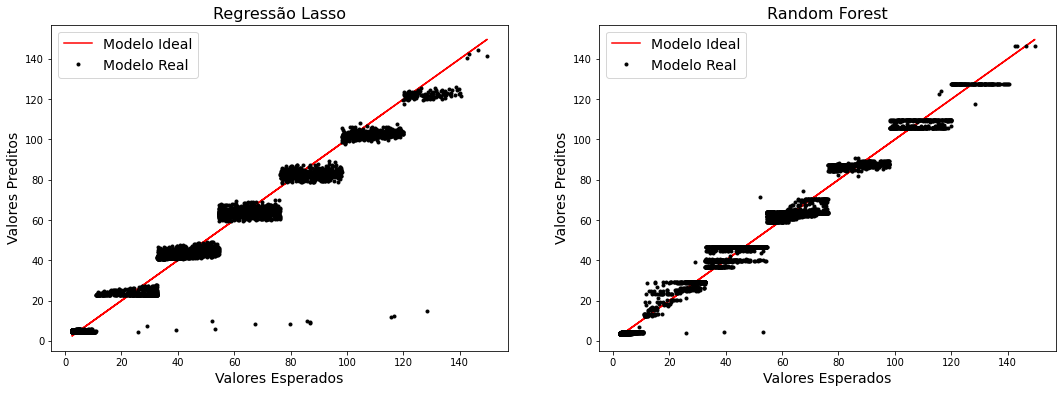

In [47]:
fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(1,2,1)
ax.plot(y_test, y_test, 'r-', label = 'Modelo Ideal')
ax.plot(y_test, yhat_lin, 'k.', label = 'Modelo Real')
ax.set_xlabel('Valores Esperados', size=14)
ax.set_ylabel('Valores Preditos', size = 14)
ax.set_title('Regressão Lasso', size = 16)
ax.legend(loc = 'best', prop={'size': 14})

ax = fig.add_subplot(1,2,2)
ax.plot(y_test, y_test, 'r-', label = 'Modelo Ideal')
ax.plot(y_test, yhat_rf, 'k.', label = 'Modelo Real')
ax.set_xlabel('Valores Esperados', size=14)
ax.set_ylabel('Valores Preditos', size = 14)
ax.set_title('Random Forest', size = 16)
ax.legend(loc = 'best', prop={'size': 14})
plt.show()

______________

## 5. Introdução ao Target Encoding

Em alguns casos, pode acontecer dos conjuntos de dados possuírem colunas com muitas classes (10 ou mais). Se formos aplicar one hot encoding para todas, cada uma dessas colunas vai produzir outras 10 ou mais colunas adicionais, de forma que o conjunto de dados final teria uma altíssima dimensionalidade. Conforme vamos ver lá em ML3, alta dimensionalidade pode ser muito ruim, de forma que o modelo pode facilmente ser *overfittado*. Assim, nesses casos, podemos utilizar uma técnica conhecida como **TargetEncoding**.

O Target Encoding é como se fosse uma codificação de variáveis categóricas de uma forma "supervisionada", onde usamos informação da variável "alvo" para codificar a variável categórica. Sendo assim, é importante realizá-la somente depois da separação treino teste para evitar o **information leakage**. Existe [esse pacote](https://contrib.scikit-learn.org/category_encoders/targetencoder.html) que implementa o Target Encoding numa forma parecida com o `scikit-learn`.

Para evitar a explosão dimensional, o Target Encoding subsitui a variável categórica pela média, mediana ou moda da variável alvo considerando somente os registros pertecentes àquela classe.

In [28]:
# criando um "alvo" numérico para as categories
categories['y'] = np.random.normal(loc = 10000, scale=2500, size = categories.shape[0])

In [29]:
# aplicando o TargetEncoder
te = TargetEncoder()
te.fit(categories[['city']], y = categories[['y']])

TargetEncoder(cols=['city'])

In [30]:
# aplicando a transformação dos dados
categories['city_te'] = te.transform(categories[['city']])
categories.head(10)

,city,city_le,city_Barcelona,city_Miami,city_Paris,city_SaoPaulo,y,city_te
0,SaoPaulo,3,0.0,0.0,0.0,1.0,9394.483929,10285.566174
1,Barcelona,0,1.0,0.0,0.0,0.0,8245.375122,9710.007157
2,Miami,1,0.0,1.0,0.0,0.0,10501.747880,10539.605556
3,SaoPaulo,3,0.0,0.0,0.0,1.0,6393.612626,10285.566174
4,SaoPaulo,3,0.0,0.0,0.0,1.0,10002.682736,10285.566174
5,SaoPaulo,3,0.0,0.0,0.0,1.0,10285.177329,10285.566174
6,Barcelona,0,1.0,0.0,0.0,0.0,14553.700801,9710.007157
7,SaoPaulo,3,0.0,0.0,0.0,1.0,10854.857146,10285.566174
8,Paris,2,0.0,0.0,1.0,0.0,9331.510796,9566.783742
9,SaoPaulo,3,0.0,0.0,0.0,1.0,9439.762643,10285.566174


In [31]:
categories.groupby('city')['y'].mean()

city
Barcelona     9710.007146
Miami        10539.673948
Paris         9566.732079
SaoPaulo     10285.571186
Name: y, dtype: float64

In [32]:
# criando um "alvo" categórico para as categories
categories['y'] = np.random.choice([0, 1],size = categories.shape[0])

In [33]:
# aplicando o TargetEncoder
te = TargetEncoder()
te.fit(categories[['city']], y = categories[['y']])

TargetEncoder(cols=['city'])

In [34]:
# aplicando a transformação dos dados
categories['city_te_categ'] = te.transform(categories[['city']])
categories.head(10)

,city,city_le,city_Barcelona,city_Miami,city_Paris,city_SaoPaulo,y,city_te,city_te_categ
0,SaoPaulo,3,0.0,0.0,0.0,1.0,1,10285.566174,0.333336
1,Barcelona,0,1.0,0.0,0.0,0.0,0,9710.007157,0.611111
2,Miami,1,0.0,1.0,0.0,0.0,0,10539.605556,0.400015
3,SaoPaulo,3,0.0,0.0,0.0,1.0,0,10285.566174,0.333336
4,SaoPaulo,3,0.0,0.0,0.0,1.0,0,10285.566174,0.333336
5,SaoPaulo,3,0.0,0.0,0.0,1.0,1,10285.566174,0.333336
6,Barcelona,0,1.0,0.0,0.0,0.0,0,9710.007157,0.611111
7,SaoPaulo,3,0.0,0.0,0.0,1.0,1,10285.566174,0.333336
8,Paris,2,0.0,0.0,1.0,0.0,1,9566.783742,0.699978
9,SaoPaulo,3,0.0,0.0,0.0,1.0,0,10285.566174,0.333336


In [35]:
categories.groupby('city')['y'].mean()

city
Barcelona    0.611111
Miami        0.400000
Paris        0.700000
SaoPaulo     0.333333
Name: y, dtype: float64

In [36]:
# aplicando no column transformer
ce_te = ColumnTransformer([('te', TargetEncoder(), ['city'])], remainder='passthrough')

# separando conjunto de teste
x_train, x_test, y_train, y_test = train_test_split(categories[['city']], categories[['y']], test_size=0.2, stratify=categories[['y']], random_state=2)

In [37]:
# criando o pipeline
pipe = Pipeline([('encoding', ce_te),('tree', DecisionTreeClassifier())])

# ajustando o pipeline
pipe.fit(x_train, y_train)

Pipeline(steps=[('encoding',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('te', TargetEncoder(),
                                                  ['city'])])),
                ('tree', DecisionTreeClassifier())])

In [38]:
# realizando novas predições
yhat = pipe.predict(x_test)

# relatório de classificação
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.60      0.60      0.60         5
           1       0.60      0.60      0.60         5

    accuracy                           0.60        10
   macro avg       0.60      0.60      0.60        10
weighted avg       0.60      0.60      0.60        10

